This notebook is specialised in the use of tsfresh in our program. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Setuping Tsfresh

run it twice

In [ ]:
pip install tsfresh

In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
!cp '/content/drive/MyDrive/ML projet/create_dataset.py' './'
!cp '/content/drive/MyDrive/ML projet/load_data.py' './'
import create_dataset
from create_dataset import * 
import load_data
from load_data import *
import seaborn as sns
from sklearn.linear_model import LogisticRegression


In [ ]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series

In [4]:
ml_folder = Path('/content/drive/MyDrive/ML projet')
ml_folder.exists()
data_path = ml_folder/'DataLFP.mat'

#### Creating tlfresh dataset

In [ ]:
X, y = create_dataset(data_path,'tjM1',0.5,0, select_amplitude=[2,3])
#Herer, we are using create_dataset and not preprocess_dataset because thoses are some old files taht are long to recalculate (several hours).

In [ ]:
def feature_dataset(X,y):
  newX = []
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      newX.append([i,j, X[i,j]])
  A = pd.DataFrame(newX, columns=["trial","time","TLS"])
  return extract_features( A,column_id="trial", column_sort="time", column_kind=None, column_value=None), y

In [ ]:
Xf, y = feature_dataset(X,y)
#Use (Xt, y) as a new dataset

Feature Extraction: 100%|██████████| 5/5 [26:11<00:00, 314.26s/it]


In [ ]:
Xf


,TLS__variance_larger_than_standard_deviation,TLS__has_duplicate_max,TLS__has_duplicate_min,TLS__has_duplicate,TLS__sum_values,TLS__abs_energy,TLS__mean_abs_change,TLS__mean_change,TLS__mean_second_derivative_central,TLS__median,TLS__mean,TLS__length,TLS__standard_deviation,TLS__variation_coefficient,TLS__variance,TLS__skewness,TLS__kurtosis,TLS__root_mean_square,TLS__absolute_sum_of_changes,TLS__longest_strike_below_mean,TLS__longest_strike_above_mean,TLS__count_above_mean,TLS__count_below_mean,TLS__last_location_of_maximum,TLS__first_location_of_maximum,TLS__last_location_of_minimum,TLS__first_location_of_minimum,TLS__percentage_of_reoccurring_values_to_all_values,TLS__percentage_of_reoccurring_datapoints_to_all_datapoints,TLS__sum_of_reoccurring_values,TLS__sum_of_reoccurring_data_points,TLS__ratio_value_number_to_time_series_length,TLS__sample_entropy,TLS__maximum,TLS__minimum,TLS__benford_correlation,TLS__time_reversal_asymmetry_statistic__lag_1,TLS__time_reversal_asymmetry_statistic__lag_2,TLS__time_reversal_asymmetry_statistic__lag_3,TLS__c3__lag_1,...,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_4,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_5,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_6,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_7,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_8,TLS__energy_ratio_by_chunks__num_segments_10__segment_focus_9,TLS__ratio_beyond_r_sigma__r_0.5,TLS__ratio_beyond_r_sigma__r_1,TLS__ratio_beyond_r_sigma__r_1.5,TLS__ratio_beyond_r_sigma__r_2,TLS__ratio_beyond_r_sigma__r_2.5,TLS__ratio_beyond_r_sigma__r_3,TLS__ratio_beyond_r_sigma__r_5,TLS__ratio_beyond_r_sigma__r_6,TLS__ratio_beyond_r_sigma__r_7,TLS__ratio_beyond_r_sigma__r_10,TLS__count_above__t_0,TLS__count_below__t_0,TLS__lempel_ziv_complexity__bins_2,TLS__lempel_ziv_complexity__bins_3,TLS__lempel_ziv_complexity__bins_5,TLS__lempel_ziv_complexity__bins_10,TLS__lempel_ziv_complexity__bins_100,TLS__fourier_entropy__bins_2,TLS__fourier_entropy__bins_3,TLS__fourier_entropy__bins_5,TLS__fourier_entropy__bins_10,TLS__fourier_entropy__bins_100,TLS__permutation_entropy__dimension_3__tau_1,TLS__permutation_entropy__dimension_4__tau_1,TLS__permutation_entropy__dimension_5__tau_1,TLS__permutation_entropy__dimension_6__tau_1,TLS__permutation_entropy__dimension_7__tau_1,TLS__query_similarity_count__query_None__threshold_0.0,"TLS__matrix_profile__feature_""min""__threshold_0.98","TLS__matrix_profile__feature_""max""__threshold_0.98","TLS__matrix_profile__feature_""mean""__threshold_0.98","TLS__matrix_profile__feature_""median""__threshold_0.98","TLS__matrix_profile__feature_""25""__threshold_0.98","TLS__matrix_profile__feature_""75""__threshold_0.98"
0,0.0,0.0,0.0,1.0,0.012444,0.000010,0.000014,4.944945e-07,1.437876e-07,-0.000002,0.000012,1000.0,0.000097,7.825861,9.484223e-09,0.693079,0.134930,0.000098,0.014166,137.0,290.0,424.0,576.0,1.000,0.999,0.009,0.008,0.326676,0.528,0.000035,-0.001050,0.701,0.511199,0.000329,-0.000208,0.954913,1.163188e-14,1.366519e-14,1.822506e-14,9.752414e-13,...,0.045976,0.039160,0.030066,0.054531,0.008640,0.026294,0.593,0.296,0.125,0.076,0.010,0.001,0.000,0.000,0.000,0.000,0.488,0.513,0.045,0.066,0.114,0.207,0.490,0.079983,0.090729,0.136002,0.181214,0.380783,1.790783,3.156292,4.688869,6.085820,6.686536,NaN,0.719831,3.041958,1.819063,1.822160,1.481545,2.179844
1,0.0,0.0,0.0,1.0,-0.028058,0.000004,0.000015,2.464965e-07,5.924349e-08,-0.000028,-0.000028,1000.0,0.000060,-2.151155,3.643047e-09,0.052899,-0.122356,0.000067,0.014795,106.0,119.0,499.0,501.0,1.000,0.999,0.520,0.519,0.392857,0.626,-0.006092,-0.016661,0.616,0.904779,0.000207,-0.000180,0.975619,5.704723e-15,7.554987e-15,9.677980e-15,-2.979658e-13,...,0.027566,0.300242,0.119726,0.118648,0.125544,0.102710,0.582,0.334,0.151,0.043,0.004,0.001,0.000,0.000,0.000,0.000,0.308,0.695,0.044,0.089,0.132,0.224,0.489,0.110453,0.159721,0.204871,0.260704,0.597595,1.783313,3.144116,4.679190,6.081715,6.721587,NaN,0.8

In [ ]:
#Saving the model so that we don't have to recompute it
Xf.to_csv("/content/drive/MyDrive/ML projet/X_tlfresh_mPFC.csv")

#### Tries using tsfresh on simple models

In [14]:
Xf = pd.read_csv("/content/drive/MyDrive/ML projet/X_tlfresh_ws1.csv")
Xf[Xf.isna()]=0

In [6]:
def bootstrapped_confidence_interval(data, stat_fun, interval=0.9):
  nb_samples = len(data)
  data = pd.DataFrame({'data' : data})
  stats = sorted([stat_fun(data.sample(nb_samples, replace=True)['data']) for _ in range(nb_samples)])
  outside = int(round((1-interval)*nb_samples/2))
  return stats[outside], stats[nb_samples-outside]

def eval_model(model, X, y):
  y_pred = cross_val_predict(model, X, y, cv=20)
  accs = [accuracy_score(y_t, y_p) for y_t, y_p in zip(np.array_split(y, 20), np.array_split(y_pred, 20))]
  ci_low, ci_high = bootstrapped_confidence_interval(accs, np.mean, interval=0.9)

  print(f'the accuracy is {np.mean(accs)} with a 90% confidence interval of [{ci_low},{ci_high}]')
  ConfusionMatrixDisplay.from_predictions(y, y_pred)
  return np.mean(accs), {ci_low}, {ci_high}

In [13]:
X, y = create_dataset(data_path,'wS1',0.5,0, select_amplitude=[2,3])

In [9]:
X_norm = normalize(X, norm='l2')
Xf_norm = normalize(Xf, norm='l2')

the accuracy is 0.5082185039370081 with a 90% confidence interval of [0.49415600393700787,0.5332185039370079]


(0.5082185039370081, {0.49415600393700787}, {0.5332185039370079})

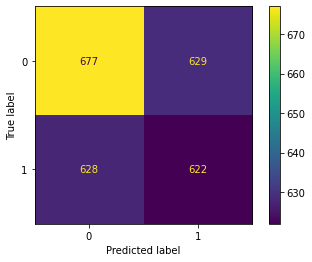

In [15]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
eval_model(model, Xf, y)
 # for j in ["wS1", "mPFC", "tjM1" ]:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


the accuracy is 0.5125307578740157 with a 90% confidence interval of [0.48930856299212594,0.5450725885826772]


(0.5125307578740157, {0.48930856299212594}, {0.5450725885826772})

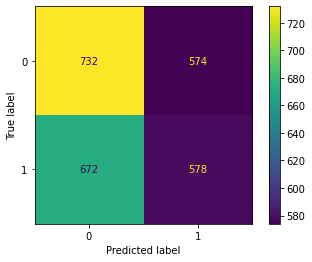

In [16]:
model = LogisticRegression()
eval_model(model, Xf, y)

####Tries using Trees on tsfresh datasets

######Instaling tree forest

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


IndexError: ignored

In [ ]:
!git clone https://github.com/johannfaouzi/pyts.git
!pip install pyts

Cloning into 'pyts'...
remote: Enumerating objects: 3366, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 3366 (delta 156), reused 142 (delta 75), pack-reused 3051
Receiving objects: 100% (3366/3366), 7.68 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (1875/1875), done.
     |████████████████████████████████| 2.5 MB 4.6 MB/s 


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd
!cp '/content/drive/MyDrive/ML projet/create_dataset.py' './'
!cp '/content/drive/MyDrive/ML projet/load_data.py' './'
import create_dataset
from create_dataset import * 
import load_data
from load_data import *
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [ ]:
def moving_average(X,n):
  X_moving=np.zeros(X.shape)
  for j in range(np.shape(X)[0]):
    X_moving[j,:]=np.convolve(X[j,:], np.ones(n)/n, mode='same')
  return X_moving

from pyts.preprocessing import RobustScaler
def robust_scale(X):
  scaler1 = RobustScaler()
  X_new=scaler1.transform(X)
  return X_new

from pyts.preprocessing import StandardScaler
def normal_scale(X):
  scaler = StandardScaler()
  X_new=scaler.transform(X)
  return X_new

from pyts.classification import TimeSeriesForest
clf = TimeSeriesForest()

from sklearn.model_selection import train_test_split #for split the data
def random_forest_classification(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
  clf.fit(X_train, y_train)
  print('accuracy--', clf.score(X_test, y_test))
  y_pred=clf.predict(X_test)
  return clf.score(X_test, y_test), y_test, y_pred

######Testing forest on tsfresh

In [ ]:
    mem1=[]
    Xf = pd.read_csv("/content/drive/MyDrive/ML projet/fresh data/X_tlfresh_ws1.csv")
    Xf[Xf.isna()]=0
    X,y=create_dataset(data_path, 'wS1', 0.5, end=0,select_amplitude=[2,3])
    for i in range(25):
      accuracy_session, y_test, y_pred=random_forest_classification(Xf,y)
      mem1.append(accuracy_session)

print(mem1)

accuracy-- 0.580078125
accuracy-- 0.58984375
accuracy-- 0.611328125
accuracy-- 0.583984375
accuracy-- 0.5859375
accuracy-- 0.615234375
accuracy-- 0.603515625
accuracy-- 0.603515625
accuracy-- 0.607421875
accuracy-- 0.578125
accuracy-- 0.583984375
accuracy-- 0.626953125
accuracy-- 0.626953125
accuracy-- 0.5859375
accuracy-- 0.58203125
accuracy-- 0.59375
accuracy-- 0.572265625
accuracy-- 0.611328125
accuracy-- 0.57421875
accuracy-- 0.56640625
accuracy-- 0.591796875
accuracy-- 0.58203125
accuracy-- 0.61328125
accuracy-- 0.59375
accuracy-- 0.58203125
[0.580078125, 0.58984375, 0.611328125, 0.583984375, 0.5859375, 0.615234375, 0.603515625, 0.603515625, 0.607421875, 0.578125, 0.583984375, 0.626953125, 0.626953125, 0.5859375, 0.58203125, 0.59375, 0.572265625, 0.611328125, 0.57421875, 0.56640625, 0.591796875, 0.58203125, 0.61328125, 0.59375, 0.58203125]


In [ ]:
mem2=[]
Xf = pd.read_csv("/content/drive/MyDrive/ML projet/fresh data/X_tlfresh_mPFC.csv")
Xf[Xf.isna()]=0
X,y=create_dataset(data_path, 'mPFC', 0.5, end=0,select_amplitude=[2,3])
for i in range(25):
    accuracy_session, y_test, y_pred=random_forest_classification(Xf,y)
    mem2.append(accuracy_session)

print(mem2)

accuracy-- 0.6167664670658682
accuracy-- 0.6197604790419161
accuracy-- 0.6317365269461078
accuracy-- 0.6317365269461078
accuracy-- 0.6317365269461078
accuracy-- 0.6317365269461078
accuracy-- 0.6017964071856288
accuracy-- 0.6047904191616766
accuracy-- 0.625748502994012
accuracy-- 0.6227544910179641
accuracy-- 0.6287425149700598
accuracy-- 0.6047904191616766
accuracy-- 0.6137724550898204
accuracy-- 0.592814371257485
accuracy-- 0.6227544910179641
accuracy-- 0.6167664670658682
accuracy-- 0.6287425149700598
accuracy-- 0.5868263473053892
accuracy-- 0.6377245508982036
accuracy-- 0.6197604790419161
accuracy-- 0.6227544910179641
accuracy-- 0.6107784431137725
accuracy-- 0.6407185628742516
accuracy-- 0.6107784431137725
accuracy-- 0.6167664670658682
[0.6167664670658682, 0.6197604790419161, 0.6317365269461078, 0.6317365269461078, 0.6317365269461078, 0.6317365269461078, 0.6017964071856288, 0.6047904191616766, 0.625748502994012, 0.6227544910179641, 0.6287425149700598, 0.6047904191616766, 0.6137724550

In [ ]:
    mem3=[]
    Xf = pd.read_csv("/content/drive/MyDrive/ML projet/fresh data/X_tlfresh_tjM1.csv")
    Xf[Xf.isna()]=0
    X,y=create_dataset(data_path, 'tjM1', 0.5, end=0,select_amplitude=[2,3])
    for i in range(25):
      accuracy_session, y_test, y_pred=random_forest_classification(Xf,y)
      mem3.append(accuracy_session)

print(mem3)

accuracy-- 0.5933333333333334
accuracy-- 0.62
accuracy-- 0.5866666666666667
accuracy-- 0.5733333333333334
accuracy-- 0.6133333333333333
accuracy-- 0.5933333333333334
accuracy-- 0.5533333333333333
accuracy-- 0.5733333333333334
accuracy-- 0.5666666666666667
accuracy-- 0.6266666666666667
accuracy-- 0.6133333333333333
accuracy-- 0.6
accuracy-- 0.5933333333333334
accuracy-- 0.6066666666666667
accuracy-- 0.58
accuracy-- 0.5866666666666667
accuracy-- 0.5933333333333334
accuracy-- 0.6
accuracy-- 0.5866666666666667
accuracy-- 0.5933333333333334
accuracy-- 0.5933333333333334
accuracy-- 0.6
accuracy-- 0.6066666666666667
accuracy-- 0.6066666666666667
accuracy-- 0.6133333333333333
[0.5933333333333334, 0.62, 0.5866666666666667, 0.5733333333333334, 0.6133333333333333, 0.5933333333333334, 0.5533333333333333, 0.5733333333333334, 0.5666666666666667, 0.6266666666666667, 0.6133333333333333, 0.6, 0.5933333333333334, 0.6066666666666667, 0.58, 0.5866666666666667, 0.5933333333333334, 0.6, 0.5866666666666667, 

In [ ]:
A=np.asarray([mem1,mem2,mem3])
tries = pd.DataFrame(A.transpose(), columns=["ws1","mPFC","tjM1"])
tries

,ws1,mPFC,tjM1
0,0.580078,0.616766,0.593333
1,0.589844,0.619760,0.620000
2,0.611328,0.631737,0.586667
3,0.583984,0.631737,0.573333
4,0.585938,0.631737,0.613333
5,0.615234,0.631737,0.593333
6,0.603516,0.601796,0.553333
7,0.603516,0.604790,0.573333
8,0.607422,0.625749,0.566667
9,0.578125,0.622754,0.626667


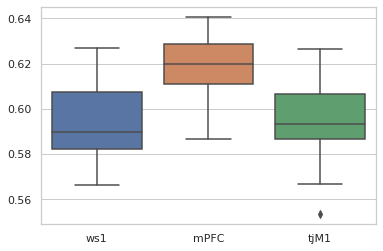

In [ ]:
sns.boxplot(data=tries)